# Wasserstein GAN Gradient Penalty

### WGAN-CP vs WGAN-GP

WGAN에서는 weight clipping을 이용하여 립시츠 조건을 만족시켜 Wasserstein 거리를 최소화하는 방식으로 학습을 한다.  
이는 기존의 GAN에 비해서는 학습이 잘되지만 때때로 다른 데이터셋에 따라서 안좋은 이미지를 생성하거나 수렴에 실패할 수 있다.  

이 논문에서는 weight clipping 을 이용하는 것 대신에 Gradient Penalty 를 이용하여 위에서 언급된 문제를 방지하기로 한다.

### Gradient Penalty

$$ Loss = \mathbb{E}_{z \sim p(z)}[D(g_\theta(z))] - \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] + λ\mathbb{E}_{	\overset{̂}{x} \sim \mathbb{P}_\overset{̂}{x}}[(||\nabla_{\overset{̂}{x}}D(\overset{̂}{x})||_2-1)^2] $$ 

기존의 WGAN은 critic이 립시츠 조건을 만족시키게 하기위해 critic의 모든 weight에 대하여 clipping을 시행했다.  
여기에선 최적의 critic에 대하여 $||\nabla_{\overset{̂}{x}}D(\overset{̂}{x})||$ 가 $x$ 와 $g_θ(z)$ 의 내분점 중 아무곳에서나 항상 1의 값을 갖는다는 것을 보여 이를 이용하여 critic loss에 규제항을 추가했다.  

추가로 본 실험에서는 critic에서 batch normalization 을 하지 않았다.  
각각의 입력데이터에 대한 기울기가 필요한데 배치 정규화를 하면 더이상 이 세팅이 유효하지 않게 되기 때문 

### 실험 결과

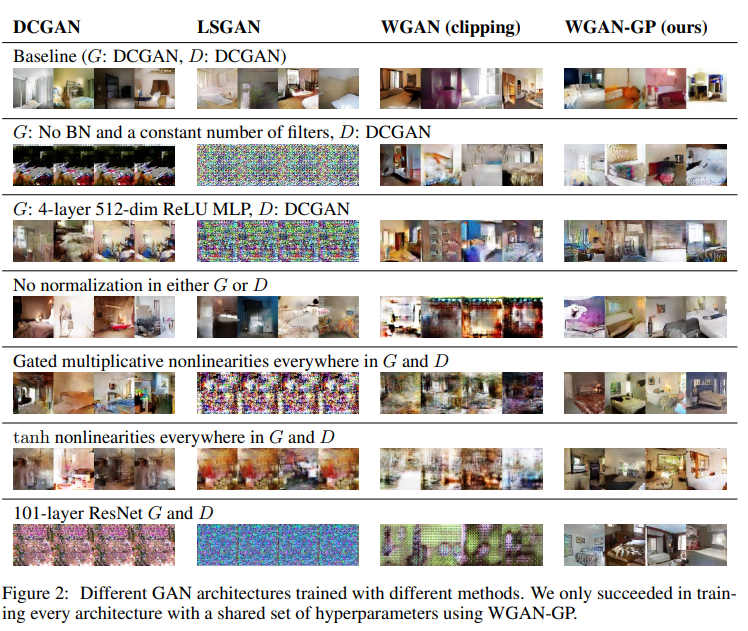

# 코드 실습

In [ ]:
# 라이브러리 임포트
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/Datasets/CelebA


In [ ]:
# 변수 정의

workers = 16
batch_size = 128
image_size = 32

nc = 3
nz = 100
ngf = 32
ndf = 32

num_epochs = 20
n_critics = 5
lr = 0.0001
weight_cliping_limit = 0.01
beta1 = 0.5
beta2 = 0.999
fig_keyframes = 20

ngpu = 1
device = torch.device('cuda' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/Datasets/CelebA

/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA


In [ ]:
!ls

img_align_celeba


In [ ]:
os.path.isdir('/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA/')

True

In [ ]:
# 데이터 로드

base_path = '/content/drive/MyDrive/Colab_Notebooks/Datasets/'
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA',
                                     transform=transforms.Compose([transforms.Resize(image_size),
                                                                   transforms.CenterCrop(image_size),
                                                                   transforms.ToTensor(),
                                                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# DCGAN 구현
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh())
        
    def forward(self, input):
      return self.main(input)
      
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
import tqdm
from tqdm.notebook import tqdm as tqdm_nb
import warnings
warnings.filterwarnings("ignore")
lamb = 10
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

img_list = []
G_losses = []
D_losses = []

total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // fig_keyframes

pbar = tqdm_nb()
piter = 0

num_epochs = 100
print("Starting Training Loop...")

for epoch in range(num_epochs):

    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        # D 학습
        netD.zero_grad()
        
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_img = netG(noise)

        # Gradient Penalty 
        e = torch.rand(b_size,1,1,1)
        e = e.expand(real_img.size()).to(device)
        fake_noise = e*real_img + (1-e)*fake_img

        fake_noise = torch.autograd.Variable(fake_noise,requires_grad=True).to(device)

        fake_noise_out = netD(fake_noise)
        grad = torch.autograd.grad(outputs=fake_noise_out,
                                   inputs=fake_noise,
                                   grad_outputs=torch.ones(fake_noise_out.size()).to(device),
                                   create_graph=True,
                                   retain_graph=True)
        grad = grad[0].to(device)
        gp = lamb * torch.mean((grad.norm(2,dim=1) - 1) ** 2)

        errD = -torch.mean(netD(real_img)) + torch.mean(netD(fake_img)) + gp
        errD.backward()
        optimizerD.step()   
        
        # G 학습
        if i % n_critics == 0:
            
            netG.zero_grad()

            gen_img = netG(noise)
            errG = -torch.mean(netD(gen_img))
            errG.backward()
            optimizerG.step()

            desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                    % (epoch+1, num_epochs, i, epoch_steps, errD.item(), errG.item())
            pbar.set_description(desc)

            G_losses.append(errG.item())
            D_losses.append(errD.item())

        # fake image 생성
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
            print(desc)

pbar.refresh()

0it [00:00, ?it/s]

Starting Training Loop...
[1/100][0/501] Loss_D: 9.9864 Loss_G: 0.0006
[3/100][250/501] Loss_D: -481.7961 Loss_G: -2091.5388
[5/100][500/501] Loss_D: -273.8521 Loss_G: -251.2105
[8/100][245/501] Loss_D: -254.0174 Loss_G: 523.5479
[10/100][495/501] Loss_D: -263.0754 Loss_G: 636.8349
[13/100][245/501] Loss_D: -85.5150 Loss_G: -1172.1337
[15/100][495/501] Loss_D: -312.2933 Loss_G: 77.7723
[18/100][245/501] Loss_D: -290.1876 Loss_G: 109.7507
[20/100][495/501] Loss_D: -246.8618 Loss_G: 341.6273
[23/100][245/501] Loss_D: -160.1460 Loss_G: -436.5038
[25/100][495/501] Loss_D: -282.4843 Loss_G: -514.9982
[28/100][245/501] Loss_D: -178.4318 Loss_G: 639.6035
[30/100][495/501] Loss_D: -116.3851 Loss_G: -133.3424
[33/100][240/501] Loss_D: -101.0324 Loss_G: -62.7507
[35/100][490/501] Loss_D: -212.7375 Loss_G: 682.3327
[38/100][240/501] Loss_D: -231.5760 Loss_G: 818.5360
[40/100][490/501] Loss_D: -80.3366 Loss_G: 485.6335
[43/100][240/501] Loss_D: -150.3214 Loss_G: -283.5034
[45/100][490/501] Loss_D:

True

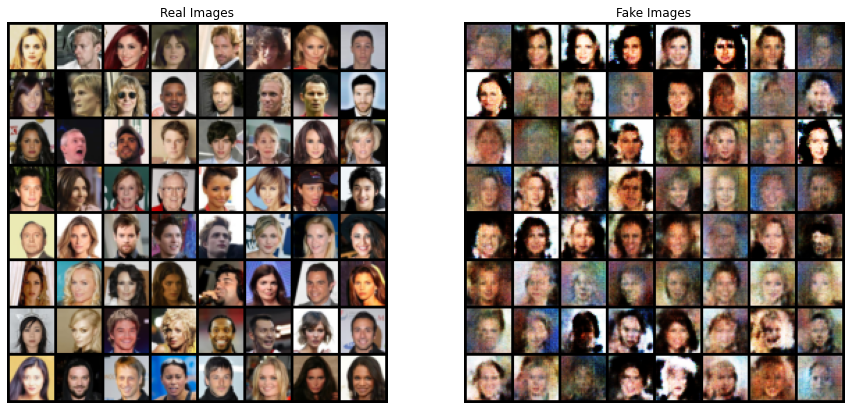

In [ ]:
# 50 epochs

real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][-1],(1,2,0)))
plt.show()

In [ ]:
# 20 epochs

for epoch in range(1,41,2):
    
  plt.figure(figsize=(7, 7))
  plt.subplot(1,1,1)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[epoch][-1],(1,2,0)))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.